In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import imageio
import cv2

from pdb import set_trace
from pathlib import Path

In [2]:
hdr_dir = Path("hdr_data")

In [3]:
# load LDR images from hdr_dir (need to unzip before)
ldr_imgs = []
for i in range(61,77):
    img_path = hdr_dir / f'memorial00{i}.png'
    ldr_imgs.append(io.imread(img_path).astype(float) / 255.0)

# linearize image

ldr_imgs = np.array(ldr_imgs)**2.2


FileNotFoundError: No such file: 'c:\Users\tranl\Documents\Stanford\Winter 2024\EE 367\EE367_FinalProject\hdr_data\memorial0061.png'

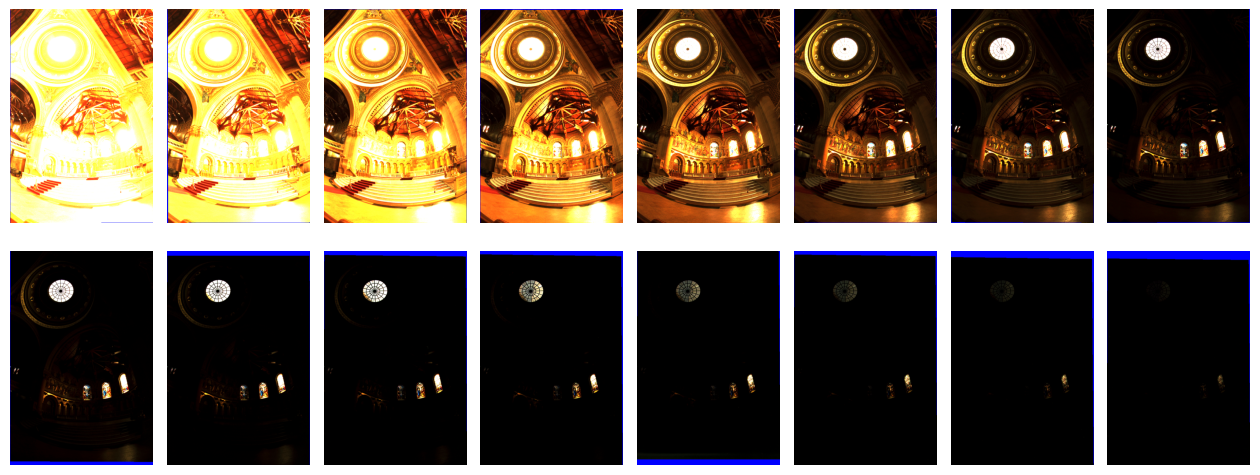

In [4]:
fig, axs = plt.subplots(2,8, figsize = (16, 6))
for i in range(16):
    r = i // 8
    c = i % 8
    axs[r,c].imshow(ldr_imgs[i])
    axs[r,c].axis('off')

fig.subplots_adjust(bottom= None, top = None, wspace=0.1, hspace=0.1)

In [5]:
# compute weights
weights = np.zeros_like(ldr_imgs)

for i in range(ldr_imgs.shape[0]):
    img = ldr_imgs[i,:,:,:]
    for c in range(3):
        img_c = img[:,:,c]
        weights[i,:,:,c] = np.exp(-4*(((img_c - 0.5)**2)/0.5**2))


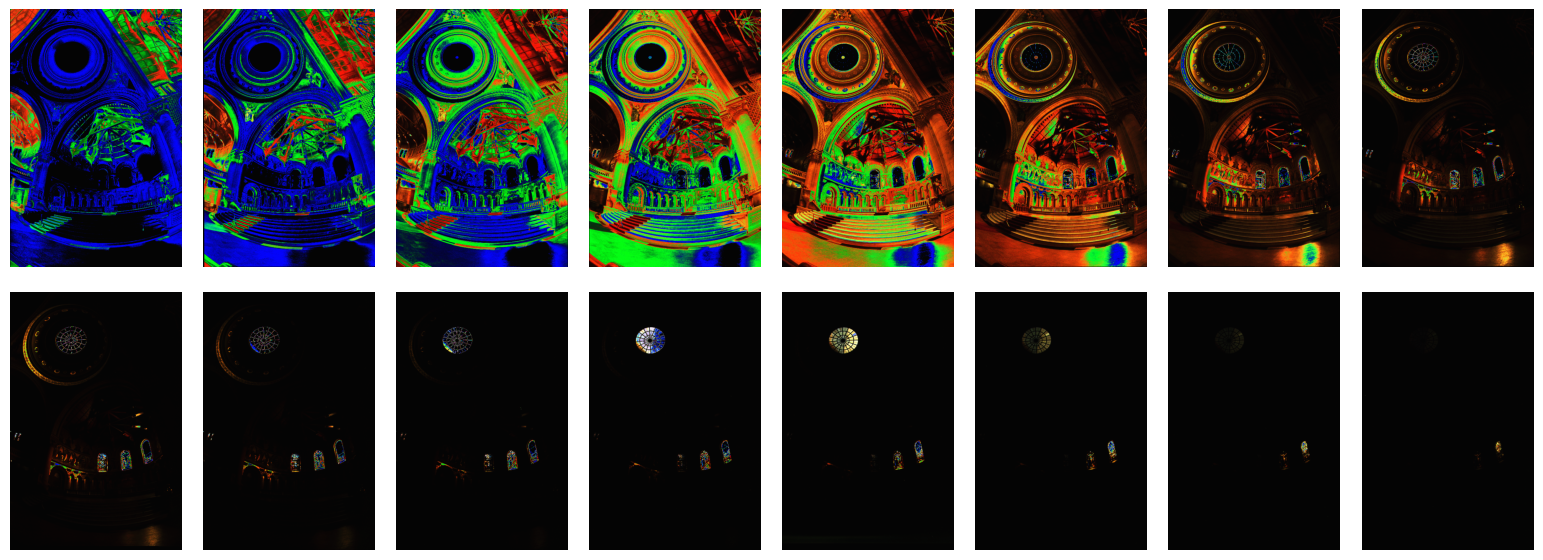

In [6]:
fig, axs = plt.subplots(2,8, figsize = (16, 6))
fig.tight_layout()
for i in range(16):
    r = i // 8
    c = i % 8
    weight = weights[i,:,:,:]
    axs[r,c].imshow(weight)
    axs[r,c].axis('off')

fig.subplots_adjust(bottom= None, top = None, wspace=0.1, hspace=0.1)

In [7]:
# fuse LDR images using weights, make sure to store your fused HDR using the name hdr

exposures = np.array([0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
exposures = 1/exposures

# initialize HDR image with all zeros
hdr = np.zeros((768, 512, 3), dtype=float)

for i in range(16):
    hdr += weights[i,:,:,:]*(np.log(ldr_imgs[i,:,:,:]+np.finfo(np.float32).eps) - np.log(exposures[i]))

In [8]:
# Normalize
scale = np.sum(weights, axis = 0)
hdr = np.exp(hdr / scale)
hdr *= 0.8371896/np.mean(hdr)  # this makes the mean of the created HDR image match the reference image (totally optional)

# convert to 32 bit floating point format, required for OpenCV
hdr = np.float32(hdr)

# crop boundary - image data here are only captured in some of the exposures, which is why they are indicated in blue in the LDR images
hdr = hdr[29:720, 19:480, :]

Text(0.5, 1.0, "Drago' tone map \n gamma = 1 \n saturation = 0.7")

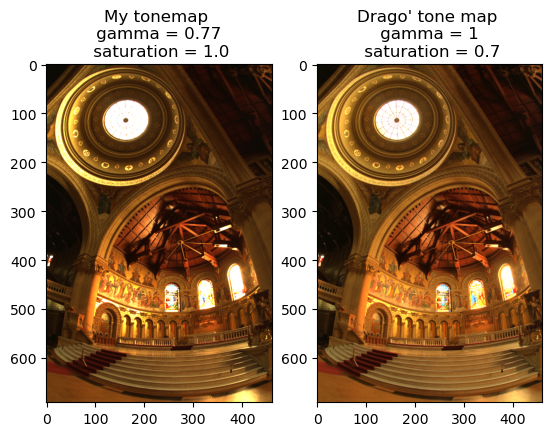

In [21]:
# my HDR tonemap

fig, axs = plt.subplots(1, 2)

my_gamma = 1/1.3
my_sat = 1.0

my_hdr = (my_sat * hdr)**my_gamma
my_hdr = np.uint8(np.clip(my_hdr, 0, 1) *255)

axs[0].imshow(my_hdr)
axs[0].set_title(f'My tonemap \n gamma = {np.round(my_gamma, 2)} \n saturation = {my_sat}')

# Drago's tonemap

# tonemap image and save LDR image using OpenCV's implementation of Drago's tonemapping operator

gamma = 1
saturation = 0.7
bias = 0.85
tonemapDrago = cv2.createTonemapDrago(gamma,saturation,bias)
ldrDrago = tonemapDrago.process(hdr)

axs[1].imshow(np.uint8( np.clip(3*ldrDrago, 0, 1) *255))
axs[1].set_title(f'Drago\' tone map \n gamma = {gamma} \n saturation = {saturation}')


In [144]:
# write HDR image (can compare to hw4_1_memorial_church.hdr reference image in an external viewer)
hdr = cv2.cvtColor(hdr, cv2.COLOR_BGR2RGB)
cv2.imwrite('my_hdr_image.hdr', hdr)

True

### My gamma-based tonemapper choices
I chose $\gamma$ = 1/1.3, saturation = 1.0 as the best values for my tonemap, since I think it preserved the features of the image the best. I do feel like Drago's tone map was better though, because it preserved more of the details and colors in the bright spots of the image like the windows. In my tonemap, it was hard to get the colors and details of the stained glass windows to show through without blacking out the details in the shadows of the image. 

### Extra testing - ignore

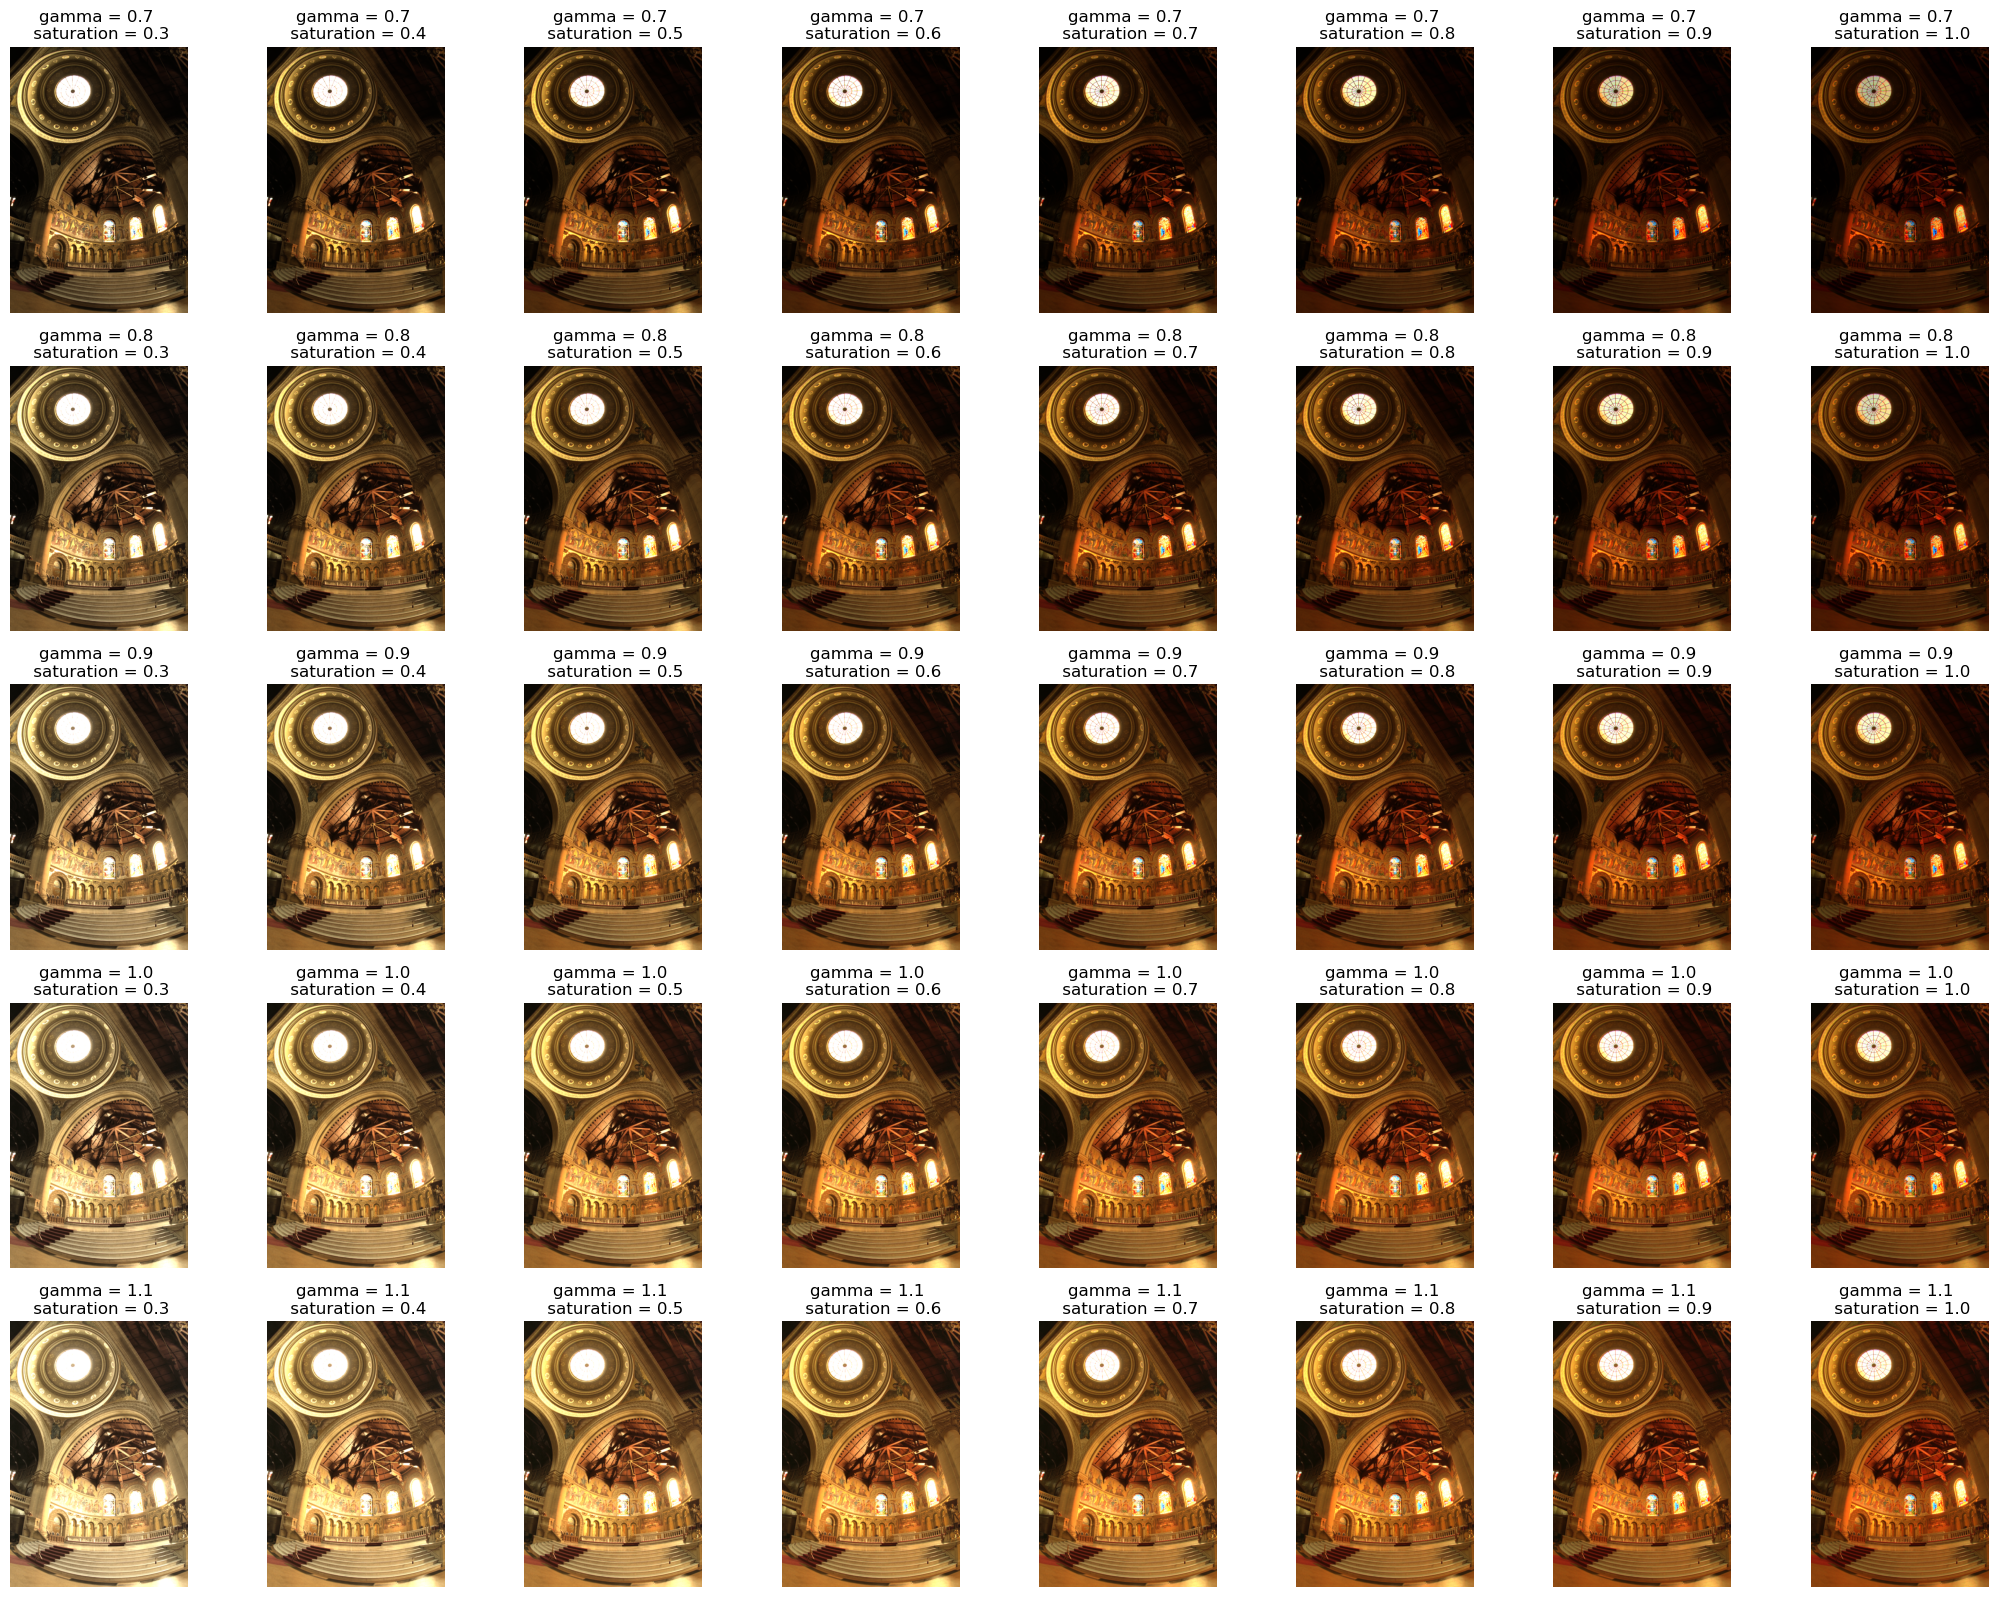

In [154]:
# Drago's Tone Map:
# plots of different gamma and saturation values

bias = 0.85
fig, axs = plt.subplots(5, 8, figsize = (26, 20))
r = 0 
gammas = np.round(np.arange(0.7, 1.1, 0.1), 1)
saturations = np.round(np.arange(0.3, 1.1, 0.1), 1)
for g in range(len(gammas)):
    c = 0
    for s in range(len(saturations)):
        tonemapDrago = cv2.createTonemapDrago(gammas[g],saturations[s],bias)
        ldrDrago = tonemapDrago.process(hdr)
        axs[r, c].imshow(np.uint8( np.clip(3*ldrDrago, 0, 1) *255))
        axs[r, c].axis('off')
        axs[r, c].set_title(f'gamma = {gammas[g]} \n saturation = {saturations[s]}')
        c += 1
    r += 1
        

Text(0.5, 1.0, 'gamma = 0.9 \n saturation = 0.6')

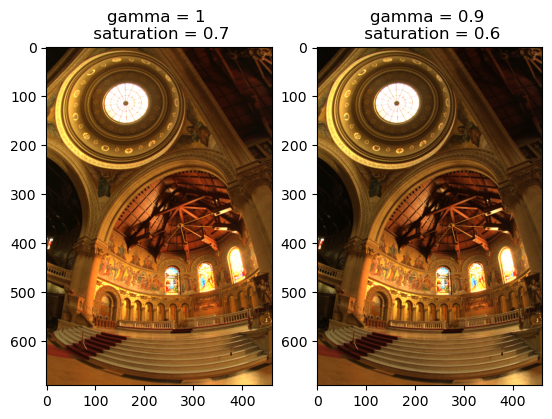

In [149]:
# tonemap image and save LDR image using OpenCV's implementation of Drago's tonemapping operator
fig, axs = plt.subplots(1, 2)

gamma = 1
saturation = 0.7
bias = 0.85
tonemapDrago = cv2.createTonemapDrago(gamma,saturation,bias)
ldrDrago = tonemapDrago.process(hdr)

axs[0].imshow(np.uint8( np.clip(3*ldrDrago, 0, 1) *255))
axs[0].set_title(f'gamma = {gamma} \n saturation = {saturation}')

# display "best" HDR
gamma = 0.9
saturation = 0.6
bias = 0.85
tonemapDrago = cv2.createTonemapDrago(gamma,saturation,bias)
ldrDrago = tonemapDrago.process(hdr)
axs[1].imshow(np.uint8( np.clip(3*ldrDrago, 0, 1) *255))
axs[1].set_title(f'gamma = {gamma} \n saturation = {saturation}')

